# Description
The notebook monitors a scheduled trading run, i.e. displays performance metrics (e.g., pnl), broker info (e.g., current balance, open positions).

Note: this is a copy of `oms/notebooks/Master_PnL_real_time_observer.old.py` adapted for scheduled trading runs.

In [1]:
# TODO(Nina): consider renaming to "System_observer".

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Imports

In [3]:

import logging
import os

import numpy as np
import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import helpers.hsystem as hsystem
import oms.broker.ccxt.ccxt_broker_instances as obccbrin
import oms.hsecrets as homssec
import reconciliation as reconcil

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [4]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-33f82bff-6d8c-4b03-8f2a-4b94dbf4103a.json'
INFO  # Git
  branch_name='CmTask8295_and_CmTask8448_nits'
  hash='0046f0eb5'
  # Last commits:
    * 0046f0eb5 Grigorii Pomazkin Cm task8328 investigate slippage (#8464)                          (   2 hours ago) Thu May 30 13:01:04 2024  (HEAD -> CmTask8295_and_CmTask8448_nits, origin/master, origin/HEAD, origin/CmTask8295_and_CmTask8448_nits)
    * fa3e9947f Juraj Smeriga CmampTask8306_RawDataReader._get_partition_mode_takes_too_long (#8337) (   3 hours ago) Thu May 30 12:28:40 2024           
    * 746f4e9b9 Vedanshu Joshi CmTask8338 Move monitoring notebook hacks to master PR2 (#8441)   (   4 hours ago) Thu May 30 11:46:04 2024           
# Machine info
  system=Linux
  node name=019787df2bb5
  release=5.15.0-1058-aws
  version=#64~20.04.1-Ubuntu SMP Tue Apr 9 11:12:27 UTC 2024
  machine=x86_64
  processor=x86_64
  cpu count=8


# Build the reconciliation config

In [5]:
# When running manually, specify the path to the config to load config from file,
# for e.g., `.../reconciliation_notebook/fast/result_0/config.pkl`.
config_file_name = None
# Set 'replace_ecs_tokyo = True' if running the notebook manually.
replace_ecs_tokyo = False
config = cconfig.get_notebook_config(
    config_file_path=config_file_name, replace_ecs_tokyo=replace_ecs_tokyo
)
if config is None:
    _LOG.info("Using hardwired config")
    # Specify the config directly when running the notebook manually.
    # Below is just an example.
    prod_data_root_dir = "/shared_data/CmTask7933/system_reconciliation"
    dag_builder_ctor_as_str = (
        "dataflow_orange.pipelines.C3.C3a_pipeline_tmp.C3a_DagBuilder_tmp"
    )
    run_mode = "paper_trading"
    start_timestamp_as_str = "20240415_131000"
    end_timestamp_as_str = "20240416_130500"
    mode = "scheduled"
    save_plots_for_investors = True
    tag = ""
    html_bucket_path = henv.execute_repo_config_code("get_html_bucket_path()")
    s3_dst_dir = os.path.join(html_bucket_path, "pnl_for_investors")
    config_list = reconcil.build_system_observer_configs(
        prod_data_root_dir,
        dag_builder_ctor_as_str,
        run_mode,
        start_timestamp_as_str,
        end_timestamp_as_str,
        mode,
        save_plots_for_investors,
        s3_dst_dir=s3_dst_dir,
        tag=tag,
    )
    config = config_list[0]
print(config)

WARNING No config found, returning None
INFO  Using hardwired config
INFO  run_date='20240415'
INFO  Using run_date=20240415
INFO  dst_root_dir='/shared_data/CmTask7933/system_reconciliation', dag_builder_name='C3a', run_mode='paper_trading', start_timestamp_as_str='20240415_131000', end_timestamp_as_str='20240416_130500'
INFO  target_dir='/shared_data/CmTask7933/system_reconciliation/C3a/paper_trading/20240415_131000.20240416_130500'
INFO  system_log_dir='system_log_dir.scheduled'
WARNING Found Config v2 flow, converting value to int.
meta: 
  dag_builder_name: C3a
  date_str: 20240415
  bar_duration: 5T
  save_plots_for_investors: True
  tag: 
s3_dst_dir: s3://cryptokaizen-html/pnl_for_investors
system_log_dir: /shared_data/CmTask7933/system_reconciliation/C3a/paper_trading/20240415_131000.20240416_130500/system_log_dir.scheduled
dag_builder_ctor_as_str: dataflow_orange.pipelines.C3.C3a_pipeline_tmp.C3a_DagBuilder_tmp
research_forecast_evaluator_from_prices: 
  init: 
    price_col: 

# System config

In [6]:
# Load the system config.
config_file_name = "system_config.output.values_as_strings.pkl"
system_config_path = os.path.join(config["system_log_dir"], config_file_name)
system_config = cconfig.load_config_from_pickle(system_config_path)
print(system_config)

dag_config: 
  compute_bar_feature: 
    in_col_groups: [('close',), ('high',), ('low',)]
    out_col_group: ()
    transformer_kwargs: 
      close_col: close
      high_col: high
      low_col: low
    drop_nans: True
  resample: 
    in_col_groups: [('close',), ('high',), ('low',), ('open',), ('stochastic',), ('volume',)]
    out_col_group: ()
    transformer_kwargs: 
      rule: 5T
      resampling_groups: [({'close': 'close'}, 'last', {}), ({'high': 'high'}, 'max', {}), ({'low': 'low'}, 'min', {}), ({'open': 'open'}, 'first', {}), ({'volume': 'volume'}, 'sum', {'min_count': '1'}), ({'close': 'twap'}, 'mean', {})]
      vwap_groups: [('close', 'volume', 'vwap'), ('stochastic', 'volume', 'cmf')]
    reindex_like_input: False
    join_output_with_input: False
  compute_vol: 
    in_col_groups: [('close',), ('high',), ('low',), ('open',)]
    out_col_group: ()
    transformer_kwargs: 
      estimators: ['close', 'parkinson', 'garman_klass']
      open_col: open
      high_col: high
  

# Last update time

In [7]:
# TODO(Grisha): tz should go to notebook's config.
tz = "ET"
current_time = hdateti.get_current_time(tz)
print(current_time)

2024-05-30 11:26:01.005560-04:00


In [8]:
portfolio_stats_dir = os.path.join(
    config["system_log_dir"], "process_forecasts", "portfolio", "statistics"
)
_LOG.info("Portfolio stats directory: %s", portfolio_stats_dir)
# Some flows below require a few bars to be already computed, we use the number of CSV Portfolio
# files in the portoflio dir as a proxy of the number of bars computed.
if os.path.exists(portfolio_stats_dir):
    cmd = f"ls {portfolio_stats_dir}"
    _, portfolio_files = hsystem.system_to_string(cmd)
    if portfolio_files == "":
        # 0 bars if dir is empty or does not exist.
        n_bars_passed = 0
    else:
        n_bars_passed = len(portfolio_files.split("\n"))
else:
    n_bars_passed = 0
_LOG.info("Bars passed: %s", n_bars_passed)

INFO  Portfolio stats directory: /shared_data/CmTask7933/system_reconciliation/C3a/paper_trading/20240415_131000.20240416_130500/system_log_dir.scheduled/process_forecasts/portfolio/statistics
INFO  Bars passed: 288


# Current balance, open positions

In [9]:
# Get Broker.
universe_version = system_config["market_data_config"]["universe_version"]
# TODO(Grisha): store `exchange, preprod, account_type, secret_id` as separate
# fields in SystemConfig.
exchange, preprod, account_type, secret_id = system_config[
    "secret_identifier_config"
].split(".")
secret_identifier = homssec.SecretIdentifier(
    exchange, preprod, account_type, secret_id
)
# Use temporary local dir in order not to override related production results
# for this run.
# TODO(Juraj): hardcoded contract type "futures".
broker = obccbrin.get_CcxtBroker_exchange_only_instance1(
    universe_version, secret_identifier, "/app/tmp.log_dir", "futures"
)

INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
File '/app/amp/im_v2/devops/env/preprod.im_db_config.env' doesn't exist
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: preprod.im_data_db
INFO  Created preprod DB connection: 
 None


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


WARNING Using secret_identifier=binance.preprod.trading.3
INFO  leverage_info={'BNB/USDT:USDT': [{'tier': 1.0, 'currency': 'USDT', 'minNotional': 0.0, 'maxNotional': 10000.0, 'maintenanceMarginRate': 0.005, 'maxLeverage': 75.0, 'info': {'bracket': '1', 'initialLeverage': '75', 'notionalCap': '10000', 'notionalFloor': '0', 'maintMarginRatio': '0.005', 'cum': '0.0'}}, {'tier': 2.0, 'currency': 'USDT', 'minNotional': 10000.0, 'maxNotional': 50000.0, 'maintenanceMarginRate': 0.006, 'maxLeverage': 50.0, 'info': {'bracket': '2', 'initialLeverage': '50', 'notionalCap': '50000', 'notionalFloor': '10000', 'maintMarginRatio': '0.006', 'cum': '10.0'}}, {'tier': 3.0, 'currency': 'USDT', 'minNotional': 50000.0, 'maxNotional': 100000.0, 'maintenanceMarginRate': 0.01, 'maxLeverage': 40.0, 'info': {'bracket': '3', 'initialLeverage': '40', 'notionalCap': '100000', 'notionalFloor': '50000', 'maintMarginRatio': '0.01', 'cum': '210.0'}}, {'tier': 4.0, 'currency': 'USDT', 'minNotional': 100000.0, 'maxNotio

INFO  This broker instance does not connect to IM database,                 only basic exchange calls (i.e. get_total_balance)                     are supported.


In [10]:
broker.get_open_positions()

INFO  No cached value for open positions: accessing exchange
INFO  open_positions={}


{}

In [11]:
total_balance = broker.get_total_balance()
_LOG.info(total_balance)

INFO  {'FDUSD': 0.0, 'BTC': 0.0, 'XRP': 0.0, 'TUSD': 0.0, 'BNB': 0.0, 'ETH': 0.05618882, 'USDT': 3.08186721, 'USDC': 0.0}


# Specify data to load

# Portfolio

## Load logged portfolios (prod)

In [12]:
# We need at least 2 bars, because the first one is NaN.
portfolio_min_bars = 2
# StatsComputer requires at least a couple of non-empty bars.
stats_computer_min_bars = 3

In [13]:
if n_bars_passed < portfolio_min_bars:
    _LOG.warning(
        "Not enough data to load portfolio stats, the number of computed bars is %s, required %s, skipping.",
        n_bars_passed,
        portfolio_min_bars,
    )
else:
    # Points to `system_log_dir/process_forecasts/portfolio`.
    data_type = "portfolio"
    portfolio_path = reconcil.get_data_type_system_log_path(
        config["system_log_dir"], data_type
    )
    _LOG.info("portfolio_path=%s", portfolio_path)
    portfolio_dfs, portfolio_stats_dfs = reconcil.load_portfolio_dfs(
        {"prod": portfolio_path},
        config["meta"]["bar_duration"],
    )
    hpandas.df_to_str(portfolio_dfs["prod"], num_rows=5, log_level=logging.INFO)

INFO  portfolio_path=/shared_data/CmTask7933/system_reconciliation/C3a/paper_trading/20240415_131000.20240416_130500/system_log_dir.scheduled/process_forecasts/portfolio
INFO  Processing portfolio=prod path=/shared_data/CmTask7933/system_reconciliation/C3a/paper_trading/20240415_131000.20240416_130500/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

holdings_shares                                                                                                                                                                                                                                                              holdings_notional                                                                                                                                                                                                                                                                  executed_trades_shares                                                                                                                                                                                                                                                              executed_trades_notional                                                                                                                                                                                                                                                                         pnl                                                                                                                                                                                                                                                             
                               6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986        1030828978  1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510  2384892553 2425308589 2484635488 2540896331  2601760471 2683705052 3065029174 3401245610 4516629366  5118394986 6051632686 8717633868 8968126878 9872743573 5115052901             6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986               6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 5115052901  3065029174 1891737434 3401245610  1464553467 1966583502 1030828978  2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553  5118394986 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
2024-04-15 09:10:00-04:00             0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0               0.0         0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0        0.0        NaN                    0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0                      NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN        NaN        NaN         NaN        NaN        NaN         NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN     

In [14]:
if n_bars_passed < portfolio_min_bars:
    _LOG.warning(
        "Not enough data to compute portfolio stats, the number of computed bars is %s, required %s, skipping.",
        n_bars_passed,
        portfolio_min_bars,
    )
else:
    portfolio_stats_df = pd.concat(portfolio_stats_dfs, axis=1)
    #
    hpandas.df_to_str(portfolio_stats_df, num_rows=5, log_level=logging.INFO)

prod                                                                                     
                                pnl gross_volume   net_volume          gmv         nmv        cash  net_wealth  leverage
2024-04-15 09:10:00-04:00       NaN          0.0          0.0          0.0         0.0       700.0       700.0       0.0
2024-04-15 09:15:00-04:00       0.0   3008.63173    -50.42419   3008.63173   -50.42419   750.42419       700.0  4.298045
                                ...          ...          ...          ...         ...         ...         ...       ...
2024-04-16 09:00:00-04:00 -0.275234  4689.195422 -1179.671358  2992.094684  -585.08486  1291.04808   705.96322  4.238315
2024-04-16 09:05:00-04:00  1.130468  3717.828712   356.734808  3047.653896 -227.219584  934.313272  707.093688  4.310113

## Compute Portfolio statistics (prod)

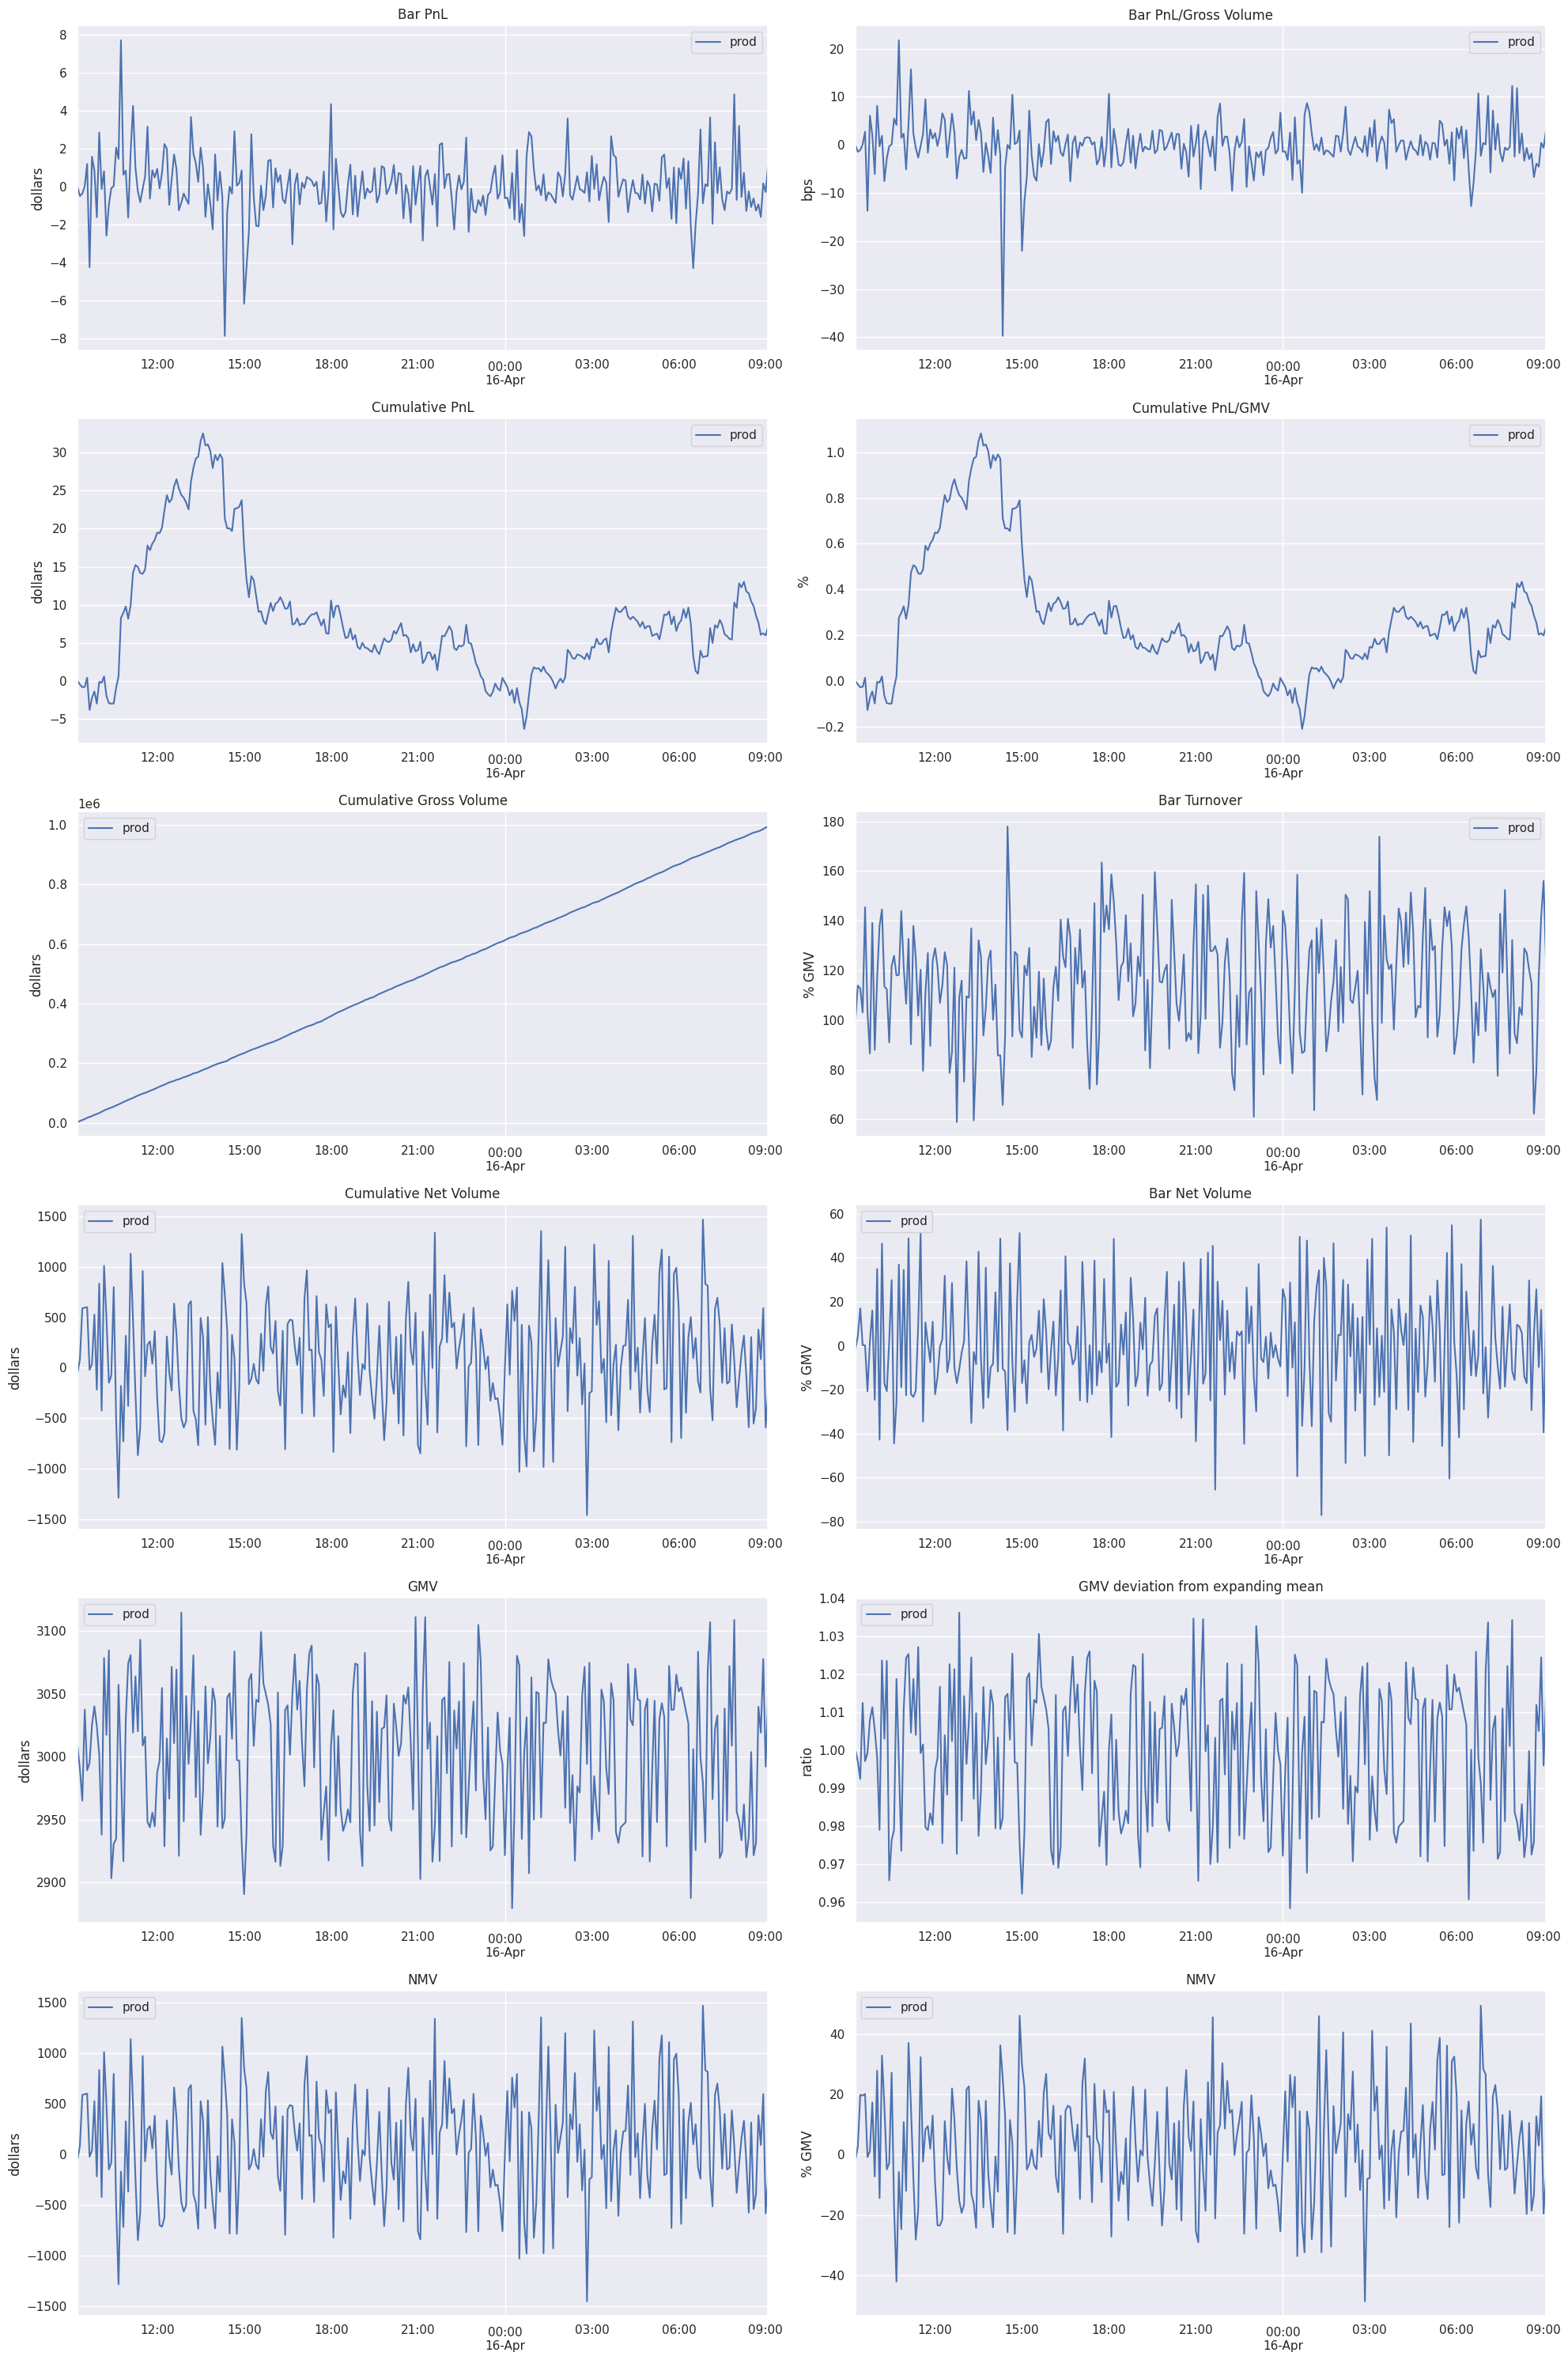

In [15]:
# There's nothing to plot if we have 2 bars only. We burn
# the first bar since it contain NaN.
if n_bars_passed < portfolio_min_bars:
    _LOG.warning(
        "Not enough data to compute portfolio stats, the number of computed bars is %s, required %s, skipping.",
        n_bars_passed,
        portfolio_min_bars,
    )
else:
    bars_to_burn = 1
    coplotti.plot_portfolio_stats(portfolio_stats_df.iloc[bars_to_burn:])

In [16]:
# We need at least 3 bars to calculate stats because we cut the first
# bar with NaNs, and stats could be calculated minimum with 2 bars.
if n_bars_passed < stats_computer_min_bars:
    _LOG.warning(
        "Not enough data to compute portfolio stats, the number of computed bars is %s, required %s, skipping.",
        n_bars_passed,
        stats_computer_min_bars,
    )
else:
    stats_computer = dtfmod.StatsComputer()
    stats_sxs, _ = stats_computer.compute_portfolio_stats(
        portfolio_stats_df.iloc[bars_to_burn:], config["meta"]["bar_duration"]
    )
    display(stats_sxs)

prod
ratios     sharpe_ratio                    5.10
           sharpe_ratio_standard_error    19.18
           sr.tval                         0.27
           sr.pval                         0.79
           kratio                         -7.49
dollar     gmv_mean                     3004.67
           gmv_stdev                      54.48
           annualized_mean_return       2599.11
           annualized_volatility         509.56
           max_drawdown                   38.86
           pnl_mean                        0.02
           pnl_std                         1.57
           turnover_mean                3462.30
           turnover_stdev                687.22
           market_bias_mean               92.97
           market_bias_stdev             538.58
percentage annualized_mean_return         86.50
           annualized_volatility          16.96
           max_drawdown                    1.29
           pnl_mean                        0.00
           pnl_std                         0.05
           turnover_mean                 115.23
           turnover_stdev                 22.87
           market_bias_mean                3.09
           market_bias_stdev              17.92

In [17]:
# Check the balance. Assert if it's below the threshold.
# TODO(Nina): pass via notebook's config.
balance_threshold = -1000
usdt_balance = total_balance["USDT"]
_LOG.info("Current USDT balance is %s $", np.round(usdt_balance, 2))
#
msg = f"USDT balance is below the threshold: {usdt_balance} < {balance_threshold} USDT"
hdbg.dassert_lt(balance_threshold, usdt_balance, msg=msg)

INFO  Current USDT balance is 3.08 $


In [18]:
if n_bars_passed < portfolio_min_bars:
    _LOG.warning(
        "Not enough data to compute portfolio stats, the number of computed bars is %s, required %s, skipping.",
        n_bars_passed,
        portfolio_min_bars,
    )
else:
    pnl = portfolio_stats_df.T.xs("pnl", level=1).T
    cum_pnl = pnl.cumsum()
    # Assert if PnL below the threshold.
    # TODO(Nina): pass via notebook's config.
    pnl_threshold = -100
    # Check the latest row, i.e. for current timestamp.
    pnl = cum_pnl["prod"].iloc[-1]
    _LOG.info("Current notional cumulative PnL is %s $", np.round(pnl, 2))
    #
    msg = f"Current notional cumulative PnL is below the threshold: {pnl} < {pnl_threshold}$"
    hdbg.dassert_lt(pnl_threshold, pnl, msg=msg)

INFO  Current notional cumulative PnL is 7.09 $


In [19]:
if n_bars_passed < portfolio_min_bars:
    _LOG.warning(
        "Not enough data to compute portfolio stats, the number of computed bars is %s, required %s, skipping.",
        n_bars_passed,
        portfolio_min_bars,
    )
else:
    # Check Current notional cumulative PnL in relative terms.
    # TODO(Nina): pass via notebook's config.
    fraction_threshold = -0.1
    #
    gmv = portfolio_stats_df.T.xs("gmv", level=1).T
    gmv = gmv.replace(0, np.nan)
    rolling_gmv = gmv.expanding().mean()
    # To compute average GMV use GMV values available up to the current point in time.
    cum_pnl_gmv = cum_pnl.divide(rolling_gmv)["prod"].iloc[-1]
    _LOG.info(
        "Current notional cumulative PnL as fraction of GMV is %s",
        np.round(cum_pnl_gmv, 5),
    )
    #
    msg = f"Current notional cumulative PnL as fraction of GMV is below the threshold {cum_pnl_gmv} < {fraction_threshold}"
    hdbg.dassert_lt(fraction_threshold, cum_pnl_gmv, msg=msg)

INFO  Current notional cumulative PnL as fraction of GMV is 0.00236


In [20]:
if n_bars_passed < portfolio_min_bars:
    _LOG.warning(
        "Not enough data to compute portfolio stats, the number of computed bars is %s, required %s, skipping.",
        n_bars_passed,
        portfolio_min_bars,
    )
else:
    gross_volume = portfolio_stats_df.T.xs("gross_volume", level=1).T
    gross_volume = gross_volume.replace(0, np.nan)
    cum_gross_volume = gross_volume.cumsum().ffill()
    #
    cum_pnl_gross_vol_bps = 1e4 * cum_pnl.iloc[-1] / cum_gross_volume.iloc[-1]
    _LOG.info(
        "Current notional cumulative PnL as fraction of cumulative gross volume in bps %s",
        np.round(cum_pnl_gross_vol_bps.iloc[0], 4),
    )

INFO  Current notional cumulative PnL as fraction of cumulative gross volume in bps 0.0714
